# Quarterly S&P 500 index Forecast, 1900-1996

[link](https://s3.amazonaws.com/MLMastery/time_series_forecasting_with_python_mini_course.pdf?__s=5rsrwvszahppe1a4vkg6)

Plan:
 1. Basic exploration
 2. Dataset visualization
 3. Forecasting (only next period vs next X periods)
  1. Persistence
  2. ARIMA
  3. Other methods: exponential smoothing
 4. Anomaly Detection
  1. Fast Fourier Transform

## Load Dataset

In [8]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib notebook

In [9]:
sp500_series = pd.read_csv('data/quarterly-sp-500-index-19001996.csv', header=0, index_col=0, squeeze=True)

Convert Year-Quarter to a datetime

In [10]:
quarters_dict = {
    'Q1' : '01',
    'Q2' : '04',
    'Q3' : '07',
    'Q4' : '10',
}

In [11]:
sp500_series.index = pd.to_datetime(
    sp500_series.index.map(lambda s: s[:4] +'-'+ quarters_dict[s[4:]]),
    format='%Y-%m'
)

## Basic Exploration

In [12]:
sp500_series.head()

1900-01-01    1.199
1900-04-01    1.300
1900-07-01    1.348
1900-10-01    1.455
1901-01-01    1.552
Name: Quarter,"Quarterly S&P 500 index, 1900-1996", dtype: float64

In [13]:
sp500_series.describe()

count    388.000000
mean       1.070796
std        0.383579
min        0.347000
25%        0.727500
50%        1.059000
75%        1.376750
max        1.965000
Name: Quarter,"Quarterly S&P 500 index, 1900-1996", dtype: float64

## Visualize the Dataset

### Line Plot

<IPython.core.display.Javascript object>


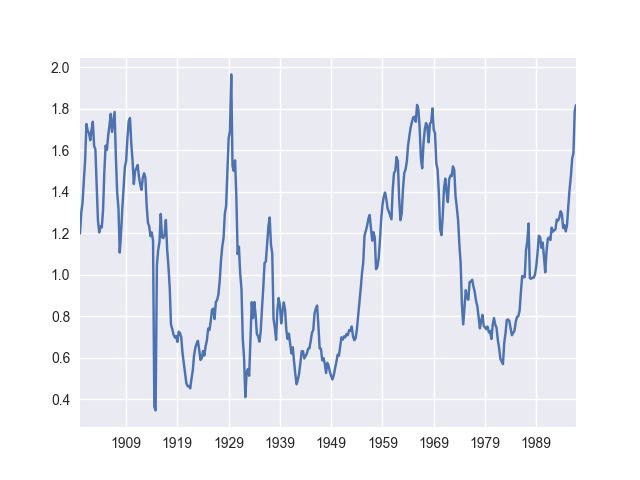

In [17]:
plt.figure()
sp500_series.plot()

### Histogram and Density Plot

<IPython.core.display.Javascript object>


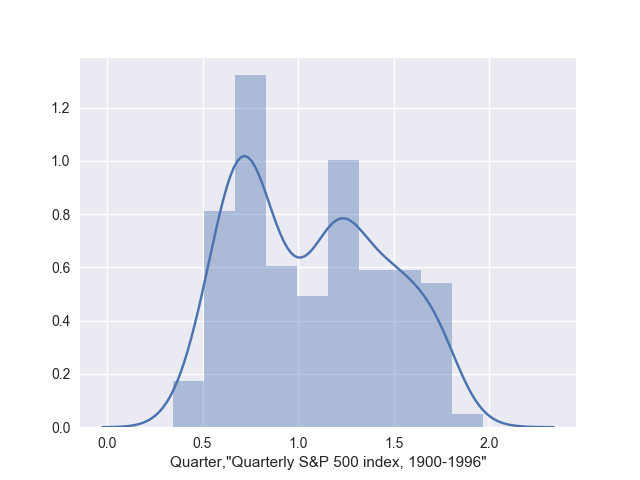

In [18]:
plt.figure()
sns.distplot(sp500_series)

### Box and Wiskers Plot...

In [19]:
def get_groups_df(groups):
    """ Returns a dataframe where each column contains the values for each group retrieved in the groupby() operation"""
    
    # Find maximum group length
    max_len = 0
    for _, group in groups:
        max_len = max(max_len, group.size)
    
    # Now fill-in a Dataframe with the groups values
    groups_df = pd.DataFrame()
    for name, group in groups:
        padding_len = max_len - len(group.values)
        groups_df[name] = np.pad(group.values, pad_width=(0, padding_len), mode='constant', constant_values=np.NaN)
    return groups_df

#### ... by Quarters

<IPython.core.display.Javascript object>


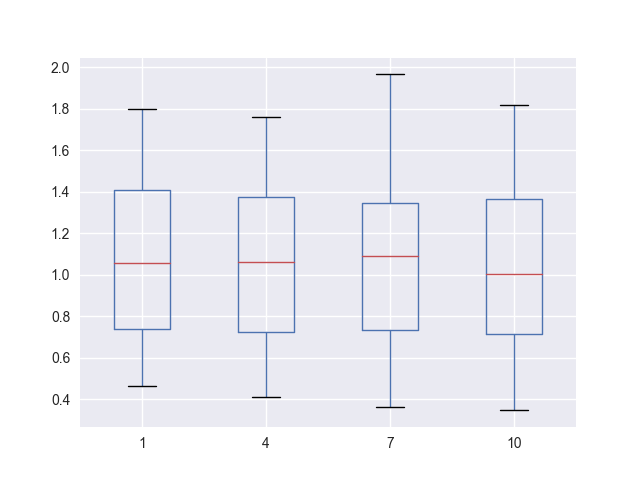

In [20]:
sp500_quarter_groups = sp500_series.groupby(sp500_series.index.month)
sp500_quarter_df = get_groups_df(sp500_quarter_groups)

plt.figure()
sp500_quarter_df.boxplot(return_type='axes')

#### ... by Decades

<IPython.core.display.Javascript object>


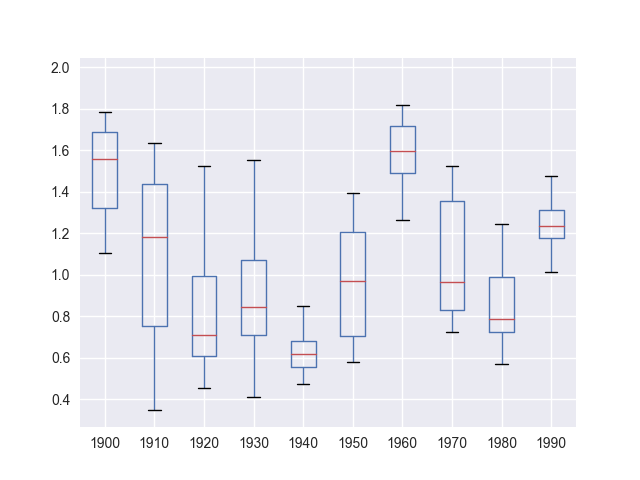

In [21]:
sp500_decades_groups = sp500_series.groupby(sp500_series.index.map(lambda date: date.year // 10 * 10))
sp500_decades_df = get_groups_df(sp500_decades_groups)

plt.figure()
sp500_decades_df.boxplot(return_type='axes')

### Heatmap

<IPython.core.display.Javascript object>


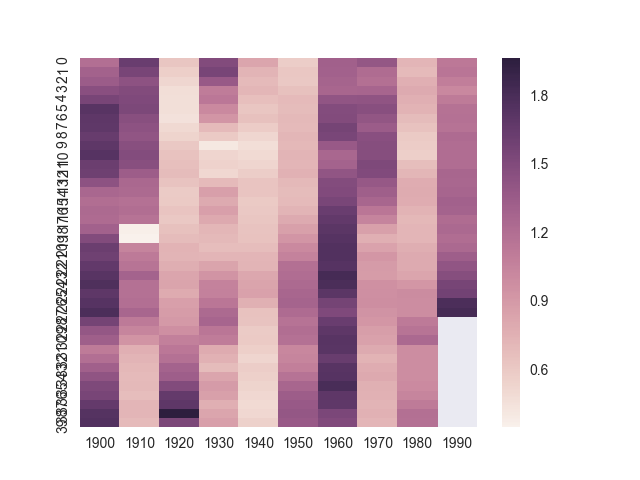

In [22]:
plt.figure()
sns.heatmap(sp500_decades_df)

### Lag Scatter Plot

In [23]:
from pandas.tools.plotting import lag_plot

<IPython.core.display.Javascript object>


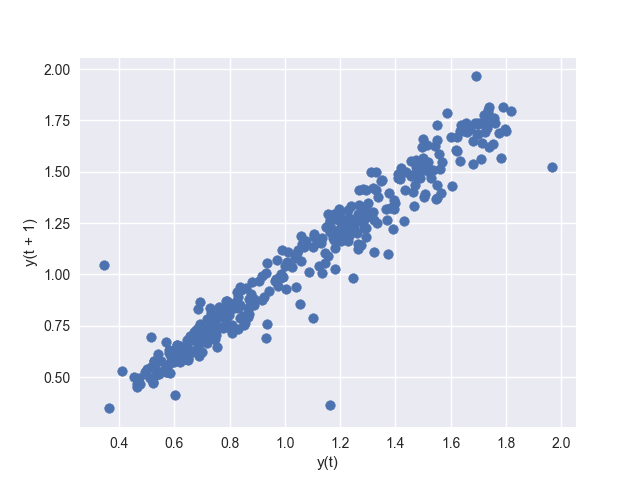

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


In [24]:
plt.figure()
lag_plot(sp500_series)

### Autocorrelation plot

 > Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. The horizontal lines displayed in the plot correspond to 95% and 99% confidence bands. The dashed line is 99% confidence band.
— from [Pandas Plotting Documentation](http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation)

<IPython.core.display.Javascript object>


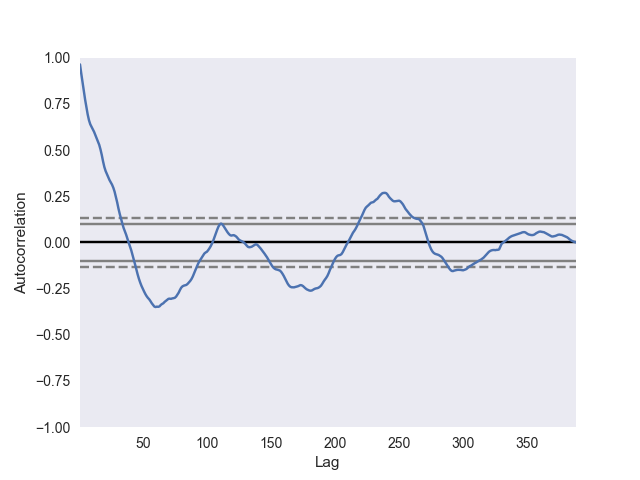

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  after removing the cwd from sys.path.


In [25]:
from pandas.tools.plotting import autocorrelation_plot

plt.figure()
autocorrelation_plot(sp500_series)

## Forecast

There are essentially two kind of time-series forecasts:
 * 1 period ahead;
 * multiple periods ahead.

As it is the most commont, we will focus on the first one. In order to predict multiple periods ahead, other methods (more based on randomness) exist: *e.g.* buy-till-you-die model.

### Prepare the dataset

In [26]:
sp500_df = pd.DataFrame({'t': sp500_series.shift(1).values, 't+1': sp500_series.values})

In [27]:
sp500_df = sp500_df.iloc[1:, :]

In [28]:
sp500_df.head()

,t,t+1
1,1.199,1.300
2,1.300,1.348
3,1.348,1.455
4,1.455,1.552
5,1.552,1.726


In [29]:
X = sp500_df['t'].values

In [30]:
y = sp500_df['t+1'].values

In [31]:
train_test_split = int(X.size * 0.8)

In [32]:
X_train, X_test = X[:train_test_split], X[train_test_split:]
y_train, y_test = y[:train_test_split], y[train_test_split:]

### Persistence Forecast Model: a baseline

In [33]:
def model_persistence(x):
    return x

In [34]:
y_persistence_pred = np.asarray([model_persistence(x) for x in X_test])

<IPython.core.display.Javascript object>


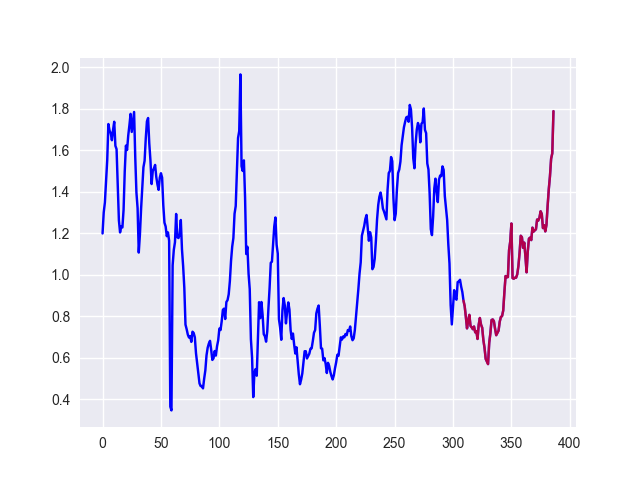

In [35]:
plt.figure()
plt.plot(range(len(X)), X, 'b-')
plt.plot(range(len(X_train), len(X)), y_persistence_pred, 'r-', alpha=0.7)

In [36]:
import math
from sklearn.metrics import mean_squared_error

In [37]:
persistence_rmse = math.sqrt(mean_squared_error(y_test, y_persistence_pred))

In [38]:
print("Root Mean Squared Error for Persistence Model: {}".format(persistence_rmse))

Root Mean Squared Error for Persistence Model: 0.06029819064343305


### ARIMA Forecast Model

AutoRegressive + Integrated (remove trend and seasonality) + Moving Average

Order:
 * **p:** number of lag observations included in the model (lag order)
 * **d:** number of times that the raw observations are differenced (degree of differencing)
 * **q:** size of the moving average window (order of moving average)
 
 
 * **p** is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
 * **d** is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing (i.e. the number of past time points to subtract from the current value) to apply to the time series. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
 * **q** is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

In [39]:
from statsmodels.tsa.arima_model import ARIMA

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [40]:
model_arima = ARIMA(X_train, order=(5, 1, 1))
model_arima_fit = model_arima.fit()

In [41]:
history = [x for x in X_train]
y_arima_pred = list()
for t in range(len(X_test)):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()[0]
    y_arima_pred.append(output)
    obs = X_test[t]
    history.append(obs)

<IPython.core.display.Javascript object>


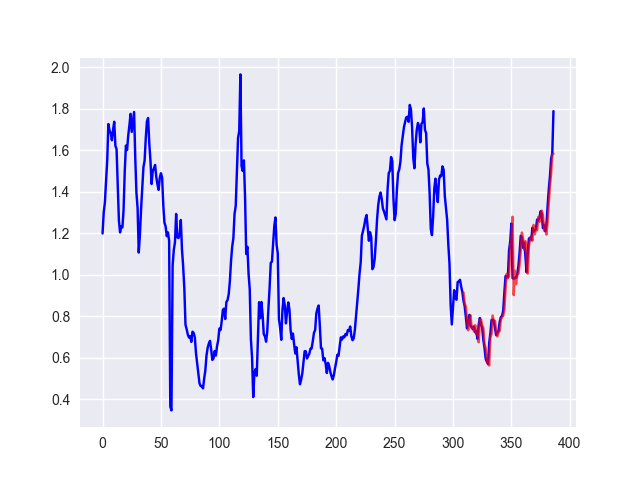

In [172]:
plt.figure()
plt.plot(range(len(X)), X, 'b-')
plt.plot(range(len(X_train), len(X)), y_arima_pred, 'r-', alpha=0.7)

In [43]:
arima_rmse = math.sqrt(mean_squared_error(y_test, y_arima_pred))

In [44]:
print("Root Mean Squared Error for ARIMA Model: {}".format(arima_rmse))

Root Mean Squared Error for ARIMA Model: 0.09195830058002194


#### Additional steps:
 * Use grid-search for parameter tunning

## LSTM

In [45]:
import math

In [46]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [48]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [49]:
dataset = sp500_df.values

In [50]:
dataset = dataset.reshape(-1, 1)

In [51]:
dataset = scaler.fit_transform(dataset)

In [52]:
train_test_split = int(dataset.size * 0.8)

In [53]:
train, test = dataset[0:train_test_split], dataset[train_test_split:]

In [54]:
def create_dataset(dataset, look_back=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back)]
        data_x.append(a)
        data_y.append(dataset[i + look_back])
    return np.array(data_x), np.array(data_y)

In [55]:
look_back = 2

In [56]:
train_x, train_y = create_dataset(train, look_back)

In [57]:
test_x, test_y = create_dataset(test, look_back)

### Model creation

In [58]:
model = Sequential()

In [59]:
model.add(LSTM(4, input_shape=train_x.shape[1:]))

In [60]:
model.add(Dense(1))

In [61]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [62]:
model.fit(train_x, train_y, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
6s - loss: 0.0631
Epoch 2/100
5s - loss: 0.0089
Epoch 3/100
5s - loss: 0.0029
Epoch 4/100
5s - loss: 0.0027
Epoch 5/100
5s - loss: 0.0027
Epoch 6/100
5s - loss: 0.0027
Epoch 7/100
5s - loss: 0.0027
Epoch 8/100
5s - loss: 0.0027
Epoch 9/100
5s - loss: 0.0026
Epoch 10/100
6s - loss: 0.0026
Epoch 11/100
5s - loss: 0.0027
Epoch 12/100
5s - loss: 0.0026
Epoch 13/100
5s - loss: 0.0026
Epoch 14/100
5s - loss: 0.0026
Epoch 15/100
5s - loss: 0.0026
Epoch 16/100
5s - loss: 0.0027
Epoch 17/100
5s - loss: 0.0025
Epoch 18/100
6s - loss: 0.0025
Epoch 19/100
5s - loss: 0.0025
Epoch 20/100
5s - loss: 0.0026
Epoch 21/100
5s - loss: 0.0025
Epoch 22/100
5s - loss: 0.0025
Epoch 23/100
5s - loss: 0.0025
Epoch 24/100
5s - loss: 0.0025
Epoch 25/100
5s - loss: 0.0025
Epoch 26/100
5s - loss: 0.0024
Epoch 27/100
5s - loss: 0.0025
Epoch 28/100
5s - loss: 0.0025
Epoch 29/100
5s - loss: 0.0024
Epoch 30/100
5s - loss: 0.0025
Epoch 31/100
5s - loss: 0.0024
Epoch 32/100
5s - loss: 0.0024
Epoch 33/100
5s -

In [63]:
train_predict = model.predict(train_x)

In [64]:
test_predict = model.predict(test_x)

In [67]:
train_predict = scaler.inverse_transform(train_predict)

In [68]:
train_y = scaler.inverse_transform(train_y)

In [69]:
test_predict = scaler.inverse_transform(test_predict)

In [70]:
test_y = scaler.inverse_transform(test_y)

In [71]:
train_score = math.sqrt(mean_squared_error(train_y, train_predict))

In [72]:
train_score

0.07405049103868667

In [73]:
test_score = math.sqrt(mean_squared_error(test_y, test_predict))

In [74]:
print("Root Mean Squared Error for LSTM Model: {}".format(test_score))

Root Mean Squared Error for LSTM Model: 0.04667030226912853


In [75]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

In [76]:
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(dataset)-1, :] = test_predict

<IPython.core.display.Javascript object>


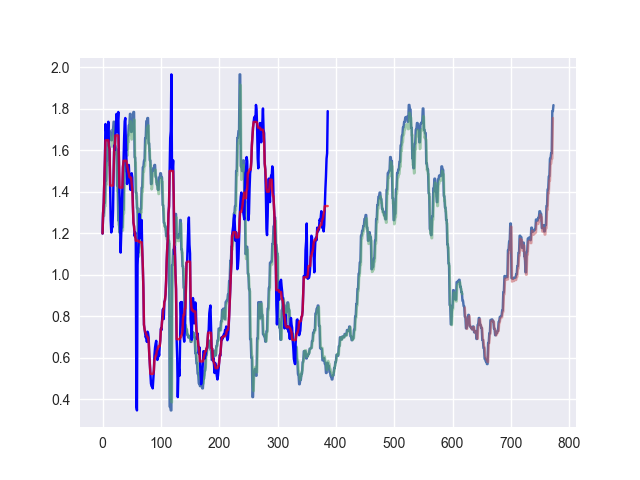

In [78]:
plt.figure()
plt.plot(scaler.inverse_transform(dataset))
plt.plot(train_predict_plot, alpha=0.5)
plt.plot(test_predict_plot, alpha=0.5)

## Anomaly detection

Inspired by [AirBnb Engineering Blog](https://medium.com/airbnb-engineering/anomaly-detection-for-airbnb-s-payment-platform-e3b0ec513199)

One option to model our time series would be to use a simple linear regression alorithm, optimized using Ordinary Least Squares. 

To encode seasonality, we could develop indicator features, for each day of the week, day of the month, etc...

Instead, we are interested not assuming any strict seasonality, and instead extract it from the data.

We want a model of the kind:
$Y = S + T + e$

$Y$: metric of interest

$S$: seasonality

$T$: trend

$e$: error term

We define anomalies the events in which the error term is too large

### Trend: 3-years rolling median

TIP: Median has better stability in case of outliers

In [79]:
from scipy.signal import medfilt

In [179]:
X_rolling_median = medfilt(X, 71)

<IPython.core.display.Javascript object>


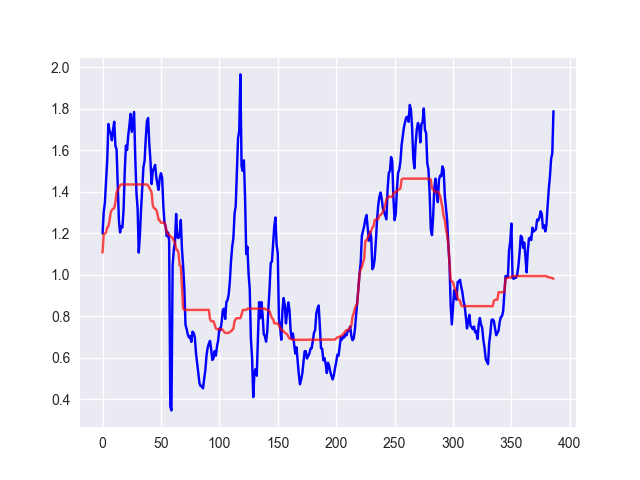

In [180]:
plt.figure()
plt.plot(X, 'b-')
plt.plot(X_rolling_median, 'r-', alpha=0.7)

In [181]:
X_detrended = X - X_rolling_median

<IPython.core.display.Javascript object>


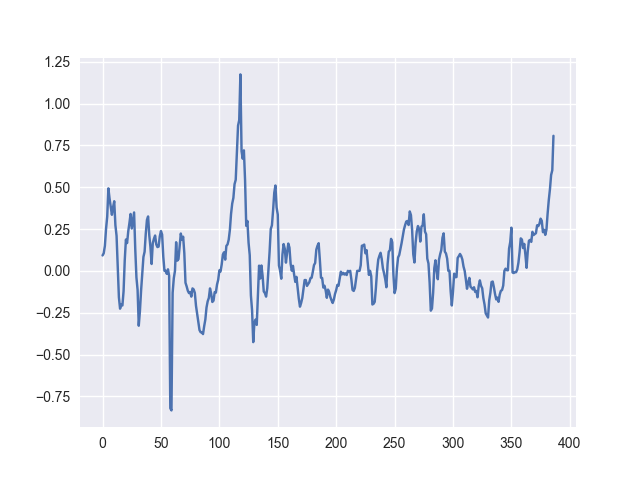

In [182]:
plt.figure()
plt.plot(X_detrended)

### Seasonality: Fast Fourier Transform

In [183]:
sampling_freq = 4.0 # number of samples per year

In [184]:
sampling_period = len(sp500_series) / sampling_freq

In [185]:
fft_x = np.fft.fft(X_detrended)
n = len(fft_x)

In [186]:
freq = np.fft.fftfreq(n, 1/sampling_freq)

In [187]:
half_n = int(np.ceil(n/2.0))

In [188]:
fft_x_half = (2.0 / n) * fft_x[:half_n]

In [189]:
freq_half = freq[:half_n]

<IPython.core.display.Javascript object>


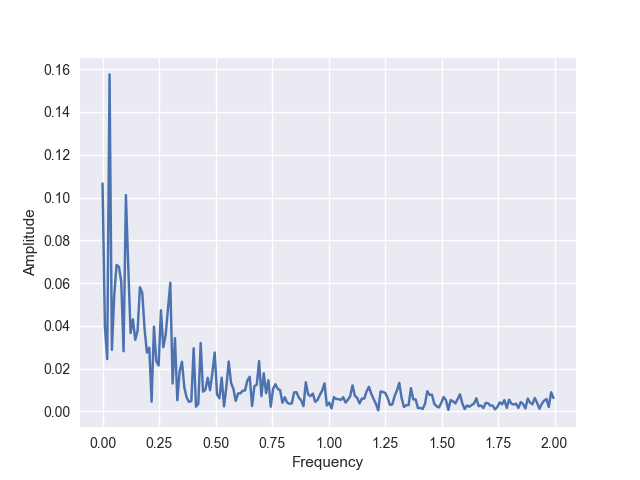

In [194]:
plt.figure()
plt.plot(freq_half, np.abs(fft_x_half))
plt.xlabel("Frequency")
plt.ylabel("Amplitude")

In [195]:
sort_idx = np.argsort(np.abs(fft_x_half))[::-1]

In [196]:
af_df = pd.DataFrame(np.hstack((np.abs(fft_x_half)[sort_idx].reshape((-1, 1)), freq_half[sort_idx].reshape((-1, 1)))), columns=['Amplitude', 'Frequency'])

In [198]:
af_df.head()

,Amplitude,Frequency
0,0.157569,0.031008
1,0.106532,0.000000
2,0.101134,0.103359
3,0.068463,0.062016
4,0.067622,0.072351


In [199]:
af_filt_df = af_df[af_df.Amplitude > 0.08]

In [200]:
selected_idx = sort_idx[:len(af_filt_df)]

In [201]:
fft_x_filt = np.zeros(fft_x.shape, dtype=fft_x.dtype)

In [202]:
fft_x_filt[selected_idx] = fft_x[selected_idx]

In [203]:
ifft_x = np.fft.ifft(fft_x_filt)

<IPython.core.display.Javascript object>


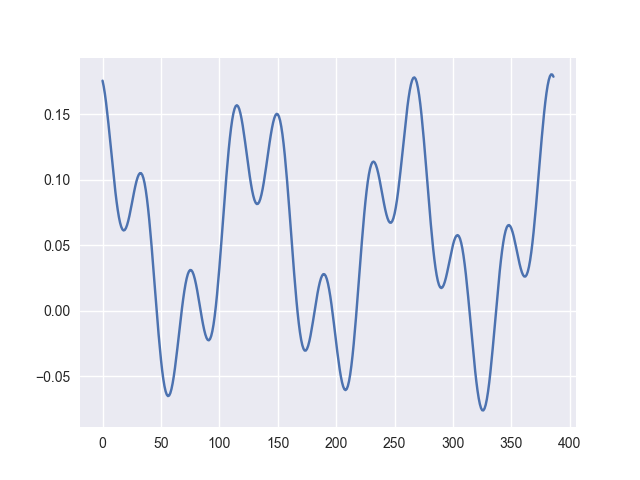

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [204]:
plt.figure()
plt.plot(ifft_x)

In [205]:
X_detrended_deseasoned = X - X_rolling_median - ifft_x

<IPython.core.display.Javascript object>


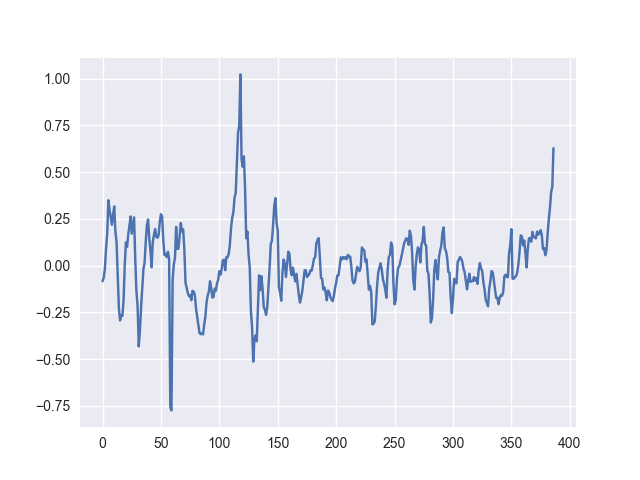

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [206]:
plt.figure()
plt.plot(X_detrended_deseasoned)

In [207]:
error_avg = np.mean(X_detrended_deseasoned)
error_std = np.std(X_detrended_deseasoned)

In [224]:
error_ths = 2*error_std

In [225]:
anomalies_idx = np.argwhere(np.abs(X_detrended_deseasoned) > error_ths).reshape((-1,))

In [226]:
sp500_series_anomalies = sp500_series.iloc[anomalies_idx]

In [227]:
sp500_series_anomalies

1907-10-01    1.107
1914-07-01    0.365
1914-10-01    0.347
1928-10-01    1.500
1929-01-01    1.659
1929-04-01    1.692
1929-07-01    1.965
1929-10-01    1.523
1930-01-01    1.500
1930-04-01    1.551
1930-07-01    1.373
1932-04-01    0.411
1996-04-01    1.585
1996-07-01    1.788
Name: Quarter,"Quarterly S&P 500 index, 1900-1996", dtype: float64

<IPython.core.display.Javascript object>


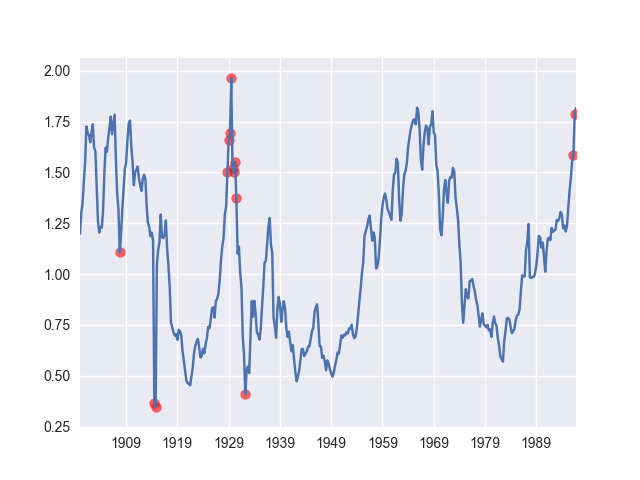

In [228]:
plt.figure()
sp500_series.plot()
plt.scatter(sp500_series_anomalies.index, sp500_series_anomalies, c='r', marker='o', alpha=0.6)

In [235]:
ifft_x.shape

(387,)

<IPython.core.display.Javascript object>


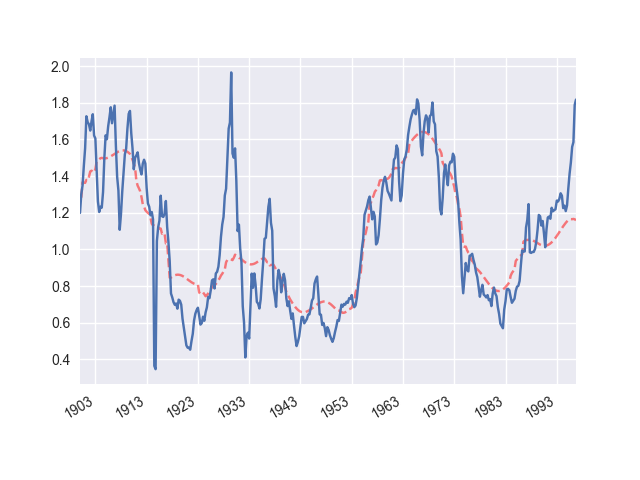

/Users/diogo.pinto/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [248]:
plt.figure()
plt.plot(sp500_series.index[1:], X_rolling_median + ifft_x, 'r--', alpha=0.5)
sp500_series.plot()